# Данные были взяты с сайта Остравок

# Импорт библиотек

In [1]:
!pip install -U nltk torchsummary wordcloud 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm_notebook, tqdm
import warnings
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from catboost import CatBoostRegressor
import re
import nltk
from nltk.corpus import stopwords
import os
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_text(text: str) -> str:
    if not text:
        return "null"
    text = text.lower()
    cleaned_text = re.sub(r'[^\w\sа-яА-ЯёЁ]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
    return cleaned_text

# Анализ полученых данных

In [5]:
data = pd.read_csv('/kaggle/input/hotel-reviews/hotel_reviews.csv')
data

,Отель,Цена,Оценка,Что было хорошо,Что было плохо
0,Апарт-отель Port Comfort on Ligovsky,от2994₽,10,"Все было отлично! Местоположение идеальное, вс...","Номер находился со стороны дороги, муж не мог ..."
1,Апарт-отель Port Comfort on Ligovsky,от2994₽,"9,7","В номере есть все необходимое, чтобы приготови...","Прямо под окном оживленная дорога, окна открыт..."
2,Апарт-отель Port Comfort on Ligovsky,от2994₽,"9,3",Отель находиться в 5 мин. средним шагом от Мос...,Описание отсутствует
3,Апарт-отель Port Comfort on Ligovsky,от2994₽,10,Описание отсутствует,Описание отсутствует
4,Апарт-отель Port Comfort on Ligovsky,от2994₽,"9,2",Описание отсутствует,Описание отсутствует
...,...,...,...,...,...
655,"Октябрьская, Нижний Новгород",от6492₽,"6,8",Доброжелательный персонал.,Немного староватый дизайн номера.
656,"Октябрьская, Нижний Новгород",от6492₽,"7,4",Быстро заселили и раньше 14:00. Расположен оте...,Уставшие номера
657,"Октябрьская, Нижний Новгород",от6492₽,"8,6","Завтраки разнообразные, всё вкусное, есть из ч...","Туалетной бумаги один рулон, не хватило"
658,"Октябрьская, Нижний Новгород",от6492₽,"8,6",Расположение очень удобное. До Чкаловской лест...,Описание отсутствует


In [6]:
data['Оценка'].value_counts()

Оценка
10                    189
Оценка отсутствует     61
9,7                    30
9                      25
8,5                    21
                     ... 
3,8                     1
5                       1
3,6                     1
3,2                     1
5,9                     1
Name: count, Length: 67, dtype: int64

In [7]:
data = data[data['Оценка'] != 'Оценка отсутствует']
data = data[(data['Что было хорошо'] != 'Описание отсутствует') & (data['Что было плохо'] != 'Описание отсутствует')]
data

,Отель,Цена,Оценка,Что было хорошо,Что было плохо
0,Апарт-отель Port Comfort on Ligovsky,от2994₽,10,"Все было отлично! Местоположение идеальное, вс...","Номер находился со стороны дороги, муж не мог ..."
1,Апарт-отель Port Comfort on Ligovsky,от2994₽,"9,7","В номере есть все необходимое, чтобы приготови...","Прямо под окном оживленная дорога, окна открыт..."
5,Апарт-отель Port Comfort on Ligovsky,от2994₽,"9,4","Удобное расположение: пару минут до метро, Мос...","Непривычно мягкие матрасы, но это больше не ми..."
6,Апарт-отель Port Comfort on Ligovsky,от2994₽,"8,6","Отель находится в центре города, очень удобное...",Уборка номера могла быть бы
7,Апарт-отель Port Comfort on Ligovsky,от2994₽,"8,7",Отличное расположение отеля На Лиговском переулке,Завтраки
...,...,...,...,...,...
651,"Октябрьская, Нижний Новгород",от6492₽,10,"Рядом основные достопримечательности: Кремль, ...","Когда заселились в номер, было холодно, батаре..."
655,"Октябрьская, Нижний Новгород",от6492₽,"6,8",Доброжелательный персонал.,Немного староватый дизайн номера.
656,"Октябрьская, Нижний Новгород",от6492₽,"7,4",Быстро заселили и раньше 14:00. Расположен оте...,Уставшие номера
657,"Октябрьская, Нижний Новгород",от6492₽,"8,6","Завтраки разнообразные, всё вкусное, есть из ч...","Туалетной бумаги один рулон, не хватило"


In [8]:
data.columns

Index(['Отель', 'Цена', 'Оценка', 'Что было хорошо', 'Что было плохо'], dtype='object')

Объеденим два признака 'Что было хорошо', 'Что было плохо' в однин признак "Отзыв"

In [9]:
data['Отзыв'] = data['Что было хорошо'].apply(lambda x: 'Что было хорошо ' + x) + data['Что было плохо'].apply(lambda x: 'Что было плохо ' + x)
data = data.drop(columns=['Что было хорошо', 'Что было плохо'])

так же предобработаем цену и оценку

In [10]:
data['Оценка'] = data['Оценка'].apply(lambda x: float(x.replace(',', '.')))
data['Цена'] = data['Цена'].apply(lambda x: float(x.replace('₽', '').replace('от', '')))
data

,Отель,Цена,Оценка,Отзыв
0,Апарт-отель Port Comfort on Ligovsky,2994.0,10.0,Что было хорошо Все было отлично! Местоположен...
1,Апарт-отель Port Comfort on Ligovsky,2994.0,9.7,"Что было хорошо В номере есть все необходимое,..."
5,Апарт-отель Port Comfort on Ligovsky,2994.0,9.4,Что было хорошо Удобное расположение: пару мин...
6,Апарт-отель Port Comfort on Ligovsky,2994.0,8.6,Что было хорошо Отель находится в центре город...
7,Апарт-отель Port Comfort on Ligovsky,2994.0,8.7,Что было хорошо Отличное расположение отеля На...
...,...,...,...,...
651,"Октябрьская, Нижний Новгород",6492.0,10.0,Что было хорошо Рядом основные достопримечател...
655,"Октябрьская, Нижний Новгород",6492.0,6.8,Что было хорошо Доброжелательный персонал.Что ...
656,"Октябрьская, Нижний Новгород",6492.0,7.4,Что было хорошо Быстро заселили и раньше 14:00...
657,"Октябрьская, Нижний Новгород",6492.0,8.6,"Что было хорошо Завтраки разнообразные, всё вк..."


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 0 to 659
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Отель   294 non-null    object 
 1   Цена    294 non-null    float64
 2   Оценка  294 non-null    float64
 3   Отзыв   294 non-null    object 
dtypes: float64(2), object(2)
memory usage: 11.5+ KB


In [12]:
data = data.reset_index(drop=True)

# Ранжировка отелей

Давайте посмотрим какие топовые отели у нас есть

In [13]:
ranking_df = data.groupby('Отель').agg(
    Средняя_оценка=('Оценка', 'mean'),
    Количество_отзывов=('Отзыв', 'count')
).reset_index()
ranking_df

,Отель,Средняя_оценка,Количество_отзывов
0,Marins Park Hotel,7.542857,7
1,"Pentahotel Moscow, Arbat",8.733333,3
2,Radisson Collection Paradise Resort and Spa,5.500000,2
3,Азалия на Московской,7.100000,6
4,Апарт Отель Лиссабон Neolit,6.600000,7
5,Апарт-отель Avenue-Apart на Малом,8.233333,6
6,Апарт-отель Karl House,4.950000,4
7,Апарт-отель Port Comfort on Ligovsky,9.280000,5
8,Апартаменты Чудо,9.640000,15
9,Гостевой дом ANI,7.828571,7


In [14]:
ranking_df['Норм_оценка'] = (ranking_df['Средняя_оценка'] - ranking_df['Средняя_оценка'].min()) / (ranking_df['Средняя_оценка'].max() - ranking_df['Средняя_оценка'].min())
ranking_df['Норм_количество_отзывов'] = (ranking_df['Количество_отзывов'] - ranking_df['Количество_отзывов'].min()) / (ranking_df['Количество_отзывов'].max() - ranking_df['Количество_отзывов'].min())
ranking_df['Рейтинг'] = (ranking_df['Норм_оценка'] + ranking_df['Норм_количество_отзывов']) / 2
ranking_df = ranking_df.sort_values(by='Рейтинг', ascending=False).reset_index(drop=True)

In [15]:
ranking_df

,Отель,Средняя_оценка,Количество_отзывов,Норм_оценка,Норм_количество_отзывов,Рейтинг
0,Отель Grand Way Haveli,9.150000,24,0.850877,1.000000,0.925439
1,Отель Grand Way Sky Dorf,8.328571,21,0.706767,0.869565,0.788166
2,Апартаменты Чудо,9.640000,15,0.936842,0.608696,0.772769
3,Парк Инн от Рэдиссон Роза Хутор,9.600000,9,0.929825,0.347826,0.638825
4,Отель У Медового моста,9.471429,7,0.907268,0.260870,0.584069
5,Отель Жемчужина Черного моря,9.162500,8,0.853070,0.304348,0.578709
6,Отель Ивмонтан,7.783333,12,0.611111,0.478261,0.544686
7,Отель Ibis Калининград Центр,8.957143,7,0.817043,0.260870,0.538956
8,Отель Villa Maria Club,9.866667,3,0.976608,0.086957,0.531782
9,Отель Европа,9.033333,6,0.830409,0.217391,0.523900


# Очистка и анализ текста

In [16]:
data['Отзыв'] = data['Отзыв'].apply(lambda x: clean_text(x))
data

,Отель,Цена,Оценка,Отзыв
0,Апарт-отель Port Comfort on Ligovsky,2994.0,10.0,отлично местоположение идеальное рядом чисто в...
1,Апарт-отель Port Comfort on Ligovsky,2994.0,9.7,номере необходимое приготовить еду постирать в...
2,Апарт-отель Port Comfort on Ligovsky,2994.0,9.4,удобное расположение пару минут метро московск...
3,Апарт-отель Port Comfort on Ligovsky,2994.0,8.6,отель находится центре города очень удобное ра...
4,Апарт-отель Port Comfort on Ligovsky,2994.0,8.7,отличное расположение отеля лиговском переулке...
...,...,...,...,...
289,"Октябрьская, Нижний Новгород",6492.0,10.0,рядом основные достопримечательности кремль ул...
290,"Октябрьская, Нижний Новгород",6492.0,6.8,доброжелательный персоналчто плохо немного ста...
291,"Октябрьская, Нижний Новгород",6492.0,7.4,быстро заселили раньше 1400 расположен отель о...
292,"Октябрьская, Нижний Новгород",6492.0,8.6,завтраки разнообразные всё вкусное выбратьчто ...


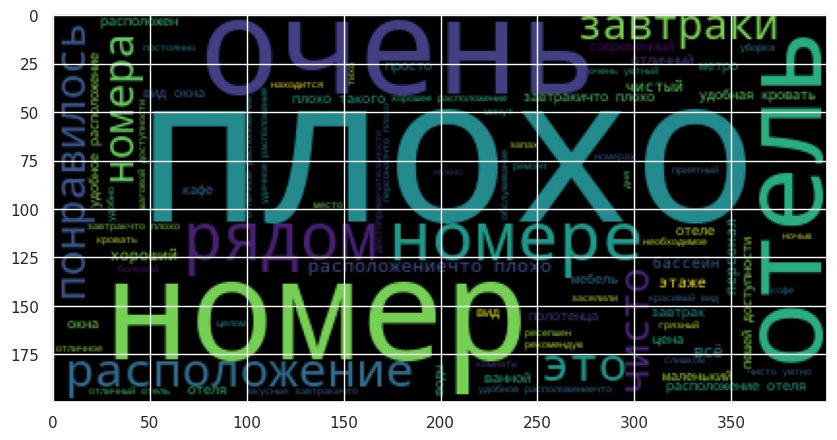

In [17]:
sns.set(rc={'figure.figsize': (10, 30)})
plt.imshow(WordCloud().generate(' '.join(data['Отзыв'].tolist())))

In [18]:
max(data['Отзыв'].apply(lambda x: len(x))), min(data['Отзыв'].apply(lambda x: len(x))), np.median(data['Отзыв'].apply(lambda x: len(x)))

(389, 21, 110.0)

# Обучим модель

## Бустинг

Чтобы не преобразовывать текст самим для этого у нас есть catboost его параметр текстовых фичей делает всю предобработку автоматически

так же т.к. таргет у нас это дробное число будем решать данную задачу регрессией

In [19]:
data.columns

Index(['Отель', 'Цена', 'Оценка', 'Отзыв'], dtype='object')

In [20]:
X = data.drop(columns=['Оценка', 'Отель'])
Y = data['Оценка']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, shuffle=True, test_size=0.1)

In [21]:
cat = CatBoostRegressor(
    iterations=1024,
    depth=6,
    random_seed=seed,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=2,
    verbose=500,
    use_best_model=True
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), text_features=['Отзыв'])

0:	learn: 1.8007623	test: 2.0043303	best: 2.0043303 (0)	total: 73.7ms	remaining: 1m 15s
500:	learn: 0.7569103	test: 1.5163277	best: 1.5163277 (500)	total: 8.52s	remaining: 8.89s
1000:	learn: 0.4693662	test: 1.4175591	best: 1.4171509 (999)	total: 17.3s	remaining: 397ms
1023:	learn: 0.4577248	test: 1.4189119	best: 1.4169131 (1005)	total: 17.7s	remaining: 0us

bestTest = 1.416913146
bestIteration = 1005

Shrink model to first 1006 iterations.


In [22]:
r2_score(Y_valid, cat.predict(X_valid))

0.48860720952236303

## Нейросеть

для данного пункта попробуем сеть BERT которая специализирована на похожую задачу, и попытаемся дообучить ее

In [23]:
X = data[['Отзыв']]
Y = data['Оценка']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, shuffle=True, test_size=0.1)

In [24]:
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Класс Dataset для PyTorch
class ReviewDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length=389):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]['Отзыв']
        target = self.targets.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

In [26]:
class RuBERTForRegression(nn.Module):
    def __init__(self, base_model):
        super(RuBERTForRegression, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # Используем представление [CLS] токена
        return self.regressor(pooled_output).squeeze()

In [27]:
train_dataset = ReviewDataset(X_train, Y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = ReviewDataset(X_valid, Y_valid, tokenizer)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RuBERTForRegression(base_model).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Epoch 1/16, Train Loss: 10.7197, Validation Loss: 3.6314, Train R2: -2.2830, Validation R2: 0.0173
Epoch 2/16, Train Loss: 3.2508, Validation Loss: 3.0324, Train R2: 0.0044, Validation R2: 0.1785
Epoch 3/16, Train Loss: 2.5658, Validation Loss: 2.7273, Train R2: 0.2142, Validation R2: 0.2770
Epoch 4/16, Train Loss: 1.5645, Validation Loss: 2.2413, Train R2: 0.5209, Validation R2: 0.4166
Epoch 5/16, Train Loss: 0.9919, Validation Loss: 1.3393, Train R2: 0.6962, Validation R2: 0.6402
Epoch 6/16, Train Loss: 0.4998, Validation Loss: 2.1933, Train R2: 0.8469, Validation R2: 0.4366
Epoch 7/16, Train Loss: 0.2728, Validation Loss: 2.3716, Train R2: 0.9165, Validation R2: 0.3762
Epoch 8/16, Train Loss: 0.2528, Validation Loss: 1.7582, Train R2: 0.9226, Validation R2: 0.5279
Epoch 9/16, Train Loss: 0.1985, Validation Loss: 1.4672, Train R2: 0.9392, Validation R2: 0.6071
Epoch 10/16, Train Loss: 0.1045, Validation Loss: 1.6660, Train R2: 0.9680, Validation R2: 0.5615
Epoch 11/16, Train Loss: 0.

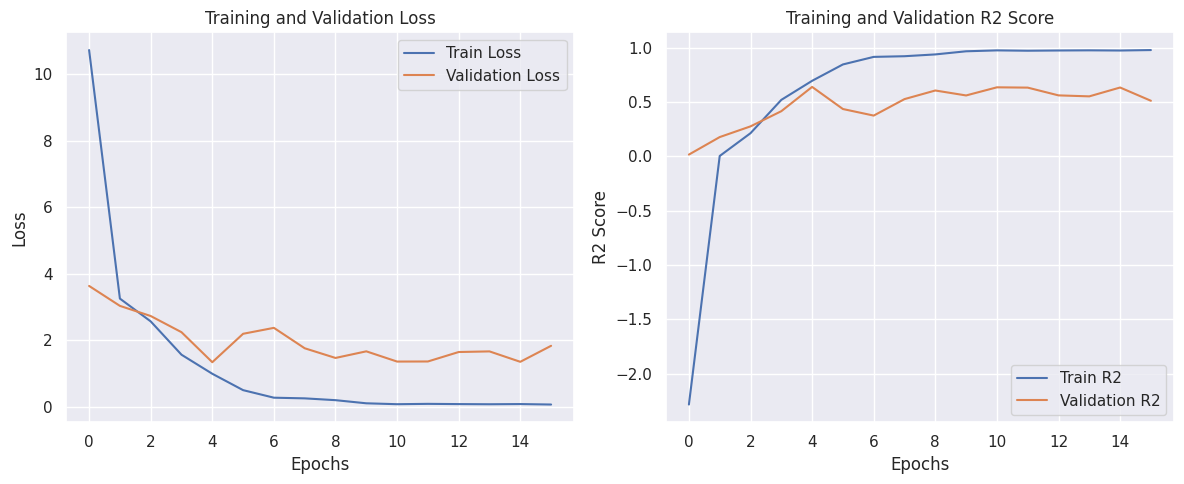

In [28]:
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, device, n_epochs=3):
    train_losses = []
    valid_losses = []
    train_r2_scores = []
    valid_r2_scores = []

    for epoch in range(n_epochs):
        # Обучение
        model.train()
        total_train_loss = 0
        train_preds = []
        train_targets = []
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
        avg_train_loss = total_train_loss / len(train_loader)
        train_r2 = r2_score(train_targets, train_preds)
        train_losses.append(avg_train_loss)
        train_r2_scores.append(train_r2)

        # Валидация
        model.eval()
        total_valid_loss = 0
        valid_preds = []
        valid_targets = []
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                targets = batch['target'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = loss_fn(outputs, targets)

                total_valid_loss += loss.item()
                valid_preds.extend(outputs.cpu().numpy())
                valid_targets.extend(targets.cpu().numpy())
        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_r2 = r2_score(valid_targets, valid_preds)
        valid_losses.append(avg_valid_loss)
        valid_r2_scores.append(valid_r2)
        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}, Train R2: {train_r2:.4f}, Validation R2: {valid_r2:.4f}')

    # Графики потерь и R^2
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # График R^2
    plt.subplot(1, 2, 2)
    plt.plot(train_r2_scores, label="Train R2")
    plt.plot(valid_r2_scores, label="Validation R2")
    plt.xlabel("Epochs")
    plt.ylabel("R2 Score")
    plt.legend()
    plt.title("Training and Validation R2 Score")

    plt.tight_layout()
    plt.show()

# Запуск обучения
train_model(model, train_loader, valid_loader, loss_fn, optimizer, device, n_epochs=16)

# Вывод

Т.к. мы получили мало данных получилась соответствующая точность, но даже для такого кол-ва данных есть хорошие метрики